# Home Flipping Price Model for King County, Washington, USA

![Home Flip](https://www.jaxdailyrecord.com/sites/default/files/styles/sliders_and_planned_story_image_870x580/public/196536_standard.png?itok=Gr72b8cv)

## Business Understanding

### Goal: Provide our house flipping company with **"Cookie Cutter House"** focused price model to better understand the variability in home price of King County Washington, USA

Our Stakeholder is a home flipping company. House flipping (Flipping) is the process of purchasing property in residential real estate, renovating the property and then selling for profit. 

#### 70% Rule

The best practice rule for house flipping is the 70% model. That is the amount spent on purchasing the home and it's renovations should be no more than 70% of the after-repair-value of the home. It's therefore extremely important to know what a home is worth as the purchasing price of the home makes up a majority of the budget.

#### The Cookie Cutter Model

The goal in house flipping is not to set a home apart from those around it but bring homes that are underperforming price-wise up to par with the surrounding neighborhood. The neighborhood determines the buying power of potential residents.

As explained, **neighborhood** (location) and **renovation** based features are important factors for home flipping.





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

## Exploratory Data Analysis

The data used in this model is from a 2014-2015 house sales in King County, Washington, USA dataset

In [2]:
# Read in Dataset

df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The above features were used to produce a 'model ready' dataset. The entire process can be seen in Data_Exploration.ipynb notebook stored in the Appendix folder. Some of the key changes made:

### Removing of Outliers
Dropped homes with duplicate ids. Only data within three standard deviations for all numerical features used in analysis were kept

In [3]:
df_cleaned = pd.read_csv('data/cleaned_data.csv')
print('Number of Homes Removed:',df.shape[0] - df_cleaned.shape[0],'| Percent of Homes Removed:', round((df.shape[0] - df_cleaned.shape[0])/df.shape[0]*100,2),'%')

Number of Homes Removed: 1236 | Percent of Homes Removed: 5.72 %


### Feature Engineering of Relative Living Area

To account for the importance of neighborhood to house flipping, a new feature called relative living area was created.

In [4]:
df['relative_living_area'] = df['sqft_living'] / df['sqft_living15']
df['relative_living_area'].describe()

count    21597.000000
mean         1.053144
std          0.320311
min          0.187279
25%          0.881188
50%          1.000000
75%          1.161039
max          6.000000
Name: relative_living_area, dtype: float64

```sqft_living```: The livable space in sqft of the home

```sqft_living15```: The average livable space in sqft of nearest 15 houses to the home

Taking the quotient gave a new feature which shows the relative amount of living space between a home and its neighbors.

![Relative Living Area](images/relative_living.png)

### Feature Engineering of Binned Zipcodes

Zipcodes were binned based on a zipcode map from King County GIS into Urban, Suburban and Rural Categories

![King County Map](images/King_County_Washington.png)

### Folium Map of Houses Divided by Community Type

In [5]:
# Choosing Which Location Subset to Show on Map - Suburb, Rural, Urban
df_show = df_cleaned.copy(deep=True)
# Divide King County up into sections and create a model for each section

lat = 47.5
long = -122.15
# Initialize a folium map to plot points
my_map = folium.Map([lat, long], zoom_start=9)


seattle = [
    # Starting point at Bottom Left of Seattle
    [47.503347, -122.255819],
    [47.734022, -122.255819],
    [47.734022, -122.419374],
    [47.503347, -122.419374],
    [47.503347, -122.255819]
]

suburbs = [
    # Starting point at Top Left of Seattle
    [47.734022, -122.419374],
    [47.777799, -122.419374],
    [47.777799, -121.998473],
    [47.362637, -122.003149],
    [47.288093, -122.177545],
    [47.257529, -122.249917],
    [47.257529, -122.419374],
    [47.503347, -122.419374],
]

rural = [
    [47.503347, -122.419374],
    [47.503347, -122.533756],
    [47.324233, -122.533756],
    [47.324233, -122.419374],
    [47.257529, -122.419374],
    [47.257529, -122.249917],
    [47.161605, -121.924595],
    [47.161605, -121.404507],
    [47.373455, -121.404507],
    [47.600453, -121.131500],
    [47.777799, -121.131500],
    [47.777799, -121.998473],
]

# Plot lines using coordinates
my_PolyLine=folium.PolyLine(locations=rural,weight=7, color = 'yellow')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=suburbs,weight=5, color = 'green')
my_map.add_child(my_PolyLine)
my_PolyLine=folium.PolyLine(locations=seattle,weight=3, color = 'blue')
my_map.add_child(my_PolyLine)
# add all the point from the file to the map object using FastMarkerCluster
my_map.add_child(FastMarkerCluster(df_show[['lat', 'long']].values.tolist()))

my_map

In the map above Blue denotes Urban, Green for Suburban and Yellow for Rural

### Creating Train and Test Datasets

In [6]:
df_cleaned.drop(['id','date','Unnamed: 0'],axis=1,inplace=True)
df_cleaned.reset_index(drop=True,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop('price', axis=1), df_cleaned['price'], test_size=0.2, random_state=42)

### Scaling Data

In [7]:
# Fit Scalar to Train
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [8]:
# Creates scaled features dataframe and then adds on price column

# Train
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df_cleaned.drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)
X_train.reset_index(drop=True,inplace=True)
X_train_final = pd.concat((X_train,y_train),axis=1)

# Test
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df_cleaned.drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

## Iterative Modeling

### Baseline Model

The baseline model was set as the mean of the training dataset.

In [9]:
# Baseline Model - Average Price of Train Dataset
baseline_mean = X_train_scaled_final['price'].mean()
model_base = DummyRegressor(strategy='mean', constant=baseline_mean)
baseline_mean

496609.12684184674

### Simple Model

The initial model was constructed using recursive feature elimination from the following features including relative living area. The RFE process can be seen in the simple_model.ipynb notebook under appendix.

In [10]:
# OLS Regression on Train Data for Simple Model

formula = 'price ~ sqft_living+view+grade+relative_living_area'
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     4206.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:57:28   Log-Likelihood:            -2.1977e+05
No. Observations:               16288   AIC:                         4.395e+05
Df Residuals:                   16283   BIC:                         4.396e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.966e+05   1372.765    361.758      0.000    4.94e+05    4.99e+05
sqft_living           9.096e+04   2405.935     37.806      0.000    8.62e+04    9.57e+04
view                  3.979e+04   1406.530     28.291      0.000     3.7e+04    4.25e+04
grade                 9.192e+04   2069.659     44.414      0.000    8.79e+04     9.6e+04
relative_living_area -1.057e+04   1693.864     -6.237      0.000   -1.39e+04   -7245.090
==============================================================================
Omnibus:                     2787.332   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6330.983
Skew:                           0.989   Prob(JB):                         0.00
Kurtosis:                       5.328   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Final Model

The final model included our binned zipcode categories

In [11]:
# Formula for OLS regression
formula = 'price ~ sqft_living+view+grade+relative_living_area+suburb+rural'

# Building Unscaled Model with Train Dataset (Used in conclusion)
model_unscaled = ols(formula,X_train_final).fit()
unscaled_coeff= pd.DataFrame(model_unscaled.params)
unscaled_coeff.rename({0:'Impact on Home Prices of Input Variables'},axis=1,inplace=True)
unscaled_coeff.drop(['Intercept'],inplace=True)
unscaled_coeff['Impact on Home Prices of Input Variables'] =  unscaled_coeff['Impact on Home Prices of Input Variables'].map(round)


# Building Scaled Model with Train Dataset
model = ols(formula,X_train_scaled_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     4069.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:57:28   Log-Likelihood:            -2.1808e+05
No. Observations:               16288   AIC:                         4.362e+05
Df Residuals:                   16281   BIC:                         4.362e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.966e+05   1238.195    401.075      0.000    4.94e+05    4.99e+05
sqft_living           1.356e+05   2292.125     59.159      0.000    1.31e+05     1.4e+05
view                  2.895e+04   1281.799     22.582      0.000    2.64e+04    3.15e+04
grade                 7.677e+04   1883.525     40.759      0.000    7.31e+04    8.05e+04
relative_living_area  -3.63e+04   1587.067    -22.875      0.000   -3.94e+04   -3.32e+04
suburb                -7.71e+04   1458.512    -52.865      0.000      -8e+04   -7.42e+04
rural                -7.382e+04   1418.382    -52.044      0.000   -7.66e+04    -7.1e+04
==============================================================================
Omnibus:                     3351.306   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10651.075
Skew:                           1.049   Prob(JB):                         0.00
Kurtosis:                       6.361   Cond. No.                         3.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Validation

### Checking R2 of Test Data

In [12]:
# Checking R2 of model with test data

y_test_pred = model.predict(X_test_scaled_final)
print('R2 of Model with Test Data:',round(r2_score(y_test,y_test_pred),3))
print('R2 of Model with Train Data:',round(model.rsquared,3))

R2 of Model with Test Data: 0.61
R2 of Model with Train Data: 0.6


### Checking RMSE

In [13]:
print('TRAIN RMSE:',rmse(y_train,y_hat_train))
print('TEST RMSE:',rmse(y_test,y_test_pred))
print('RMSE DIFF:', abs(rmse(y_train,y_hat_train)-rmse(y_test,y_test_pred)))

NameError: name 'y_hat_train' is not defined

### Checking Normal Distribution of Input Variables

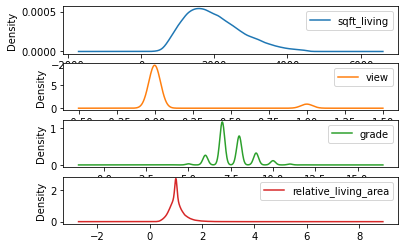

In [ ]:
df_cleaned.filter(['sqft_living','view','grade','relative_living_area','suburb,rural'],axis=1).plot.kde(subplots=True,sharex=False)
plt.show()

### Checking Normal Distribution of Residuals

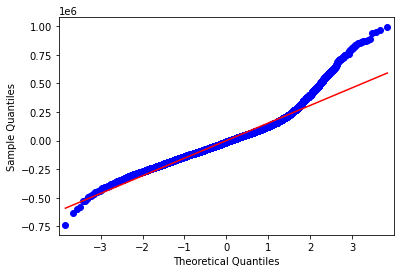

In [ ]:
y_hat_train = model.predict(X_train_scaled)

qqplot(y_train-y_hat_train,line='r')
plt.show()

### Checking for Heteroskedasticity and Lack of Trend in Errors

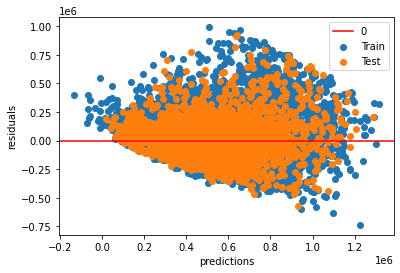

In [ ]:
plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_test_pred, y_test - y_test_pred, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Checking Multicollinearity

<AxesSubplot:>

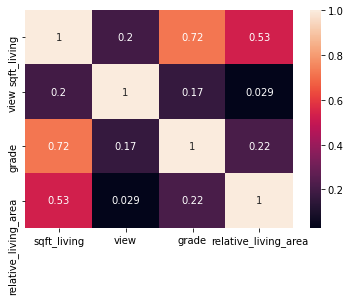

In [ ]:
sns.heatmap(X_train_scaled.filter(['sqft_living','view','grade','relative_living_area','suburb,rural'],axis=1).corr().abs(),annot=True)

There was one correlation coefficient between input variables above 0.7 (grade and sqft living). Both input variables were kept in due to their importance for home flipping and the high ranking each one had with respect to explaining the variability in home price.

## Conclusion

Our final model ended up explaining 61% of the variability in home price for King County.

In [ ]:
# Show input variables with their unscaled coefficient in order of significance
unscaled_coeff['significance rank'] = [1,6,3,5,2,4]
unscaled_coeff.sort_values('significance rank',ascending=True)

,Impact on Home Prices of Input Variables,significance rank
sqft_living,177,1
suburb,-155636,2
grade,71959,3
rural,-227240,4
relative_living_area,-122010,5
view,102738,6


#### Location
Within that model we found that location has a significant impact on home price. Choosing a home flipping project outside the city will on average lower the total maximum income for that project. When considering a budget for a home flipping project outside the city, the lower market value should be factored in. Budgets for suburban and rural projects should be lower than for projects in Seattle.

#### Renovation Features
When picking features to focus on for renovation, livable space and construction grade should be prioritized. So when renovating a home projects like finishing a basement or adding a guest house would be effective, along with using quality materials for these projects.

## Future Research

* Expand dataset to include a larger timeframe of home sales in King County

* Explore other neighborhood metrics including proximity to schools and amenities.

* Also, during our analysis we found that relative livable space had a small but significant negative association with home price. That is, there is a negative price impact as a home’s livable space gets bigger while the living space of its neighbors stays the same. This reinforces the cookie cutter model approach and it would be interesting to see if other relative metrics have impacts on a home price.


## Citations

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

https://www.ramseysolutions.com/real-estate/how-to-flip-a-house

https://www.investopedia.com/articles/mortgages-real-estate/08/house-flip.asp
